# <code>TORCH.AUTOGRAD</code>를 사용한 자동 미분
* 신경망을 학습할 때 가장 자주 사용되는 알고리즘은 Back Propagation이다.
* 이 알고리즘에서 Parameter(weight)는 Parameter에 대한 손실함수의 변화도(gradient)에 따라 조정된다.
* 이러한 변화도를 계산하기 위해 PyTorch에는 <code>torch.autograd</code>라고 불리는 <b>자동 미분 엔진</b>이 내장되어 있다.
* 이는 모든 <b>연산 그래프</b>에 대한 변화도의 자동 계산을 지원한다.
* 입력 x, 매개변수 w, b 그리고 일부 Loss Function이 있는 가장 간단한 단일 계층 신경망을 가정해보자. PyTorch에서는 다음과 같이 정의할 수 있다.

In [29]:
import torch

x = torch.ones(5) # input tensor
y = torch.zeros(3) # expected output
w = torch.randn(5, 3, requires_grad=True)
b = torch.randn(3, requires_grad=True)
z = torch.matmul(x, w) + b

loss = torch.nn.functional.binary_cross_entropy_with_logits(z, y)

In [30]:
print(loss)

tensor(1.7794, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


In [33]:
z.grad_fn

In [34]:
z.requires_grad

True

In [18]:
y.requires_grad

False

# Tensor, Function과 연산 그래프 (Computational Graph)
* 위 코드는 다음의 연산 그래프를 정의한다.
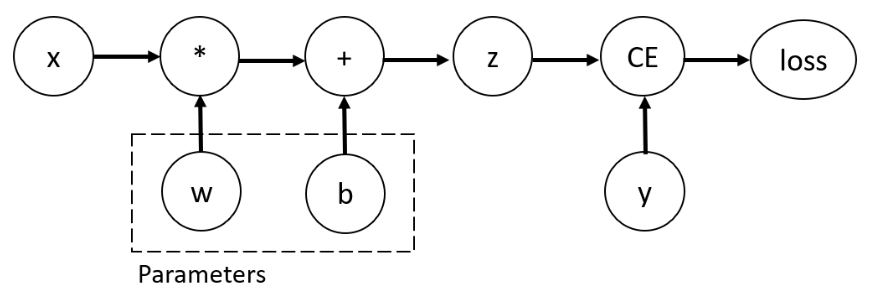

* 이 신경망에서, w와 b는 <b>최적화</b>를 해야 하는 매개변수이다.
* 따라서 이러한 변수들에 대한 손실 함수의 변화도를 계산할 수 있어야 한다.
* 이를 위해서 해당 텐서에 <code>requires_grad</code>를 설정한다.
* default가 False라 했는데 학습할 땐 무조건 필요한 거 아닌가? -> 이런 경우에는 어떻게 되지?
* Tensor의 default는 완전히 False는 아닌 듯 하다. 위의 z를 보면 변수 선언에 대해 input에 Tensor가 있는 경우 미분의 대상 여부에서 가능하기 때문에 이러한 경우에는 <code>requires_grad</code>가 True가 된다고 판단된다.
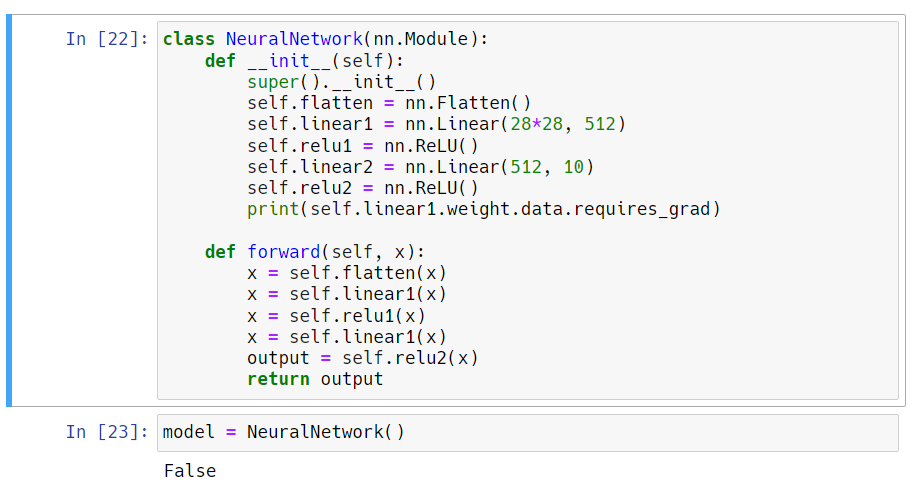
* 위와 같이 나옴 -> 뭐지?
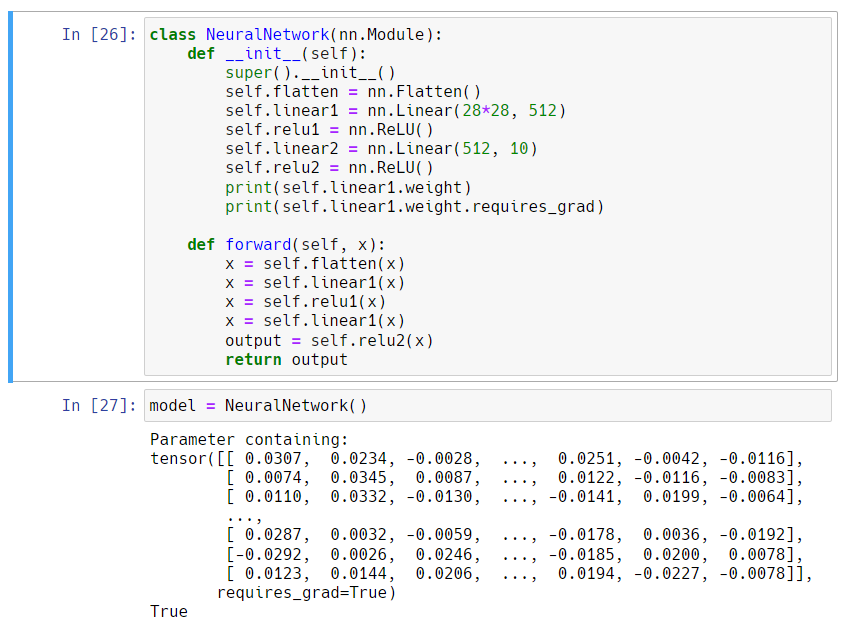
* 2번 이미지는 <code>.data</code>를 통해 새로운 <code>Tensor</code>를 만들어서 그런 듯하다.
* <b>즉, 우리가 인위적으로 만들어낸 <code>Tensor</code>에 대해서는 <code>requires_grad</code>가 <code>False</code>이지만, <code>nn.Module</code>에서 제공하는 Layer에 들어간 <code>weight</code>의 <code>Tensor</code>는 <code>requires_grad</code>가 <code>True</code>로 추측된다.</b> 
* 더 정확히 말하면, <code>weight</code>에 사용된 <code>Tensor</code>는 사실 <code>Tensor</code>가 아니다. <code>Parameter</code>라는 다른 객체이고, 이 객체의 원형 혹은 객체 컨테이너가 가지고 있는 원소 중 하나가 <code>Tensor</code>로 추측된다.
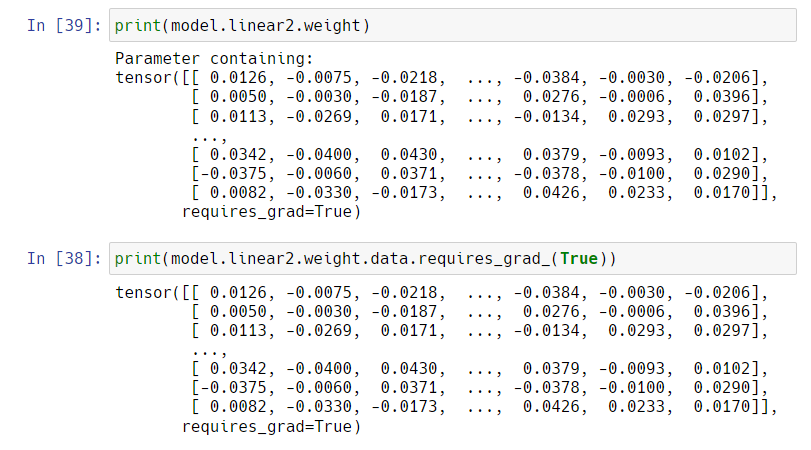
* <code>requires_grad</code>의 값은 텐서를 생성할 때 설정하거나, 나중에 <code>x.requires_grad_(True)</code> 메서드를 사용하여 나중에 설정할 수도 있다.
* <code>Autograd</code> 관련 <a href="https://kingnamji.tistory.com/44">링크</a>

# Function Class
* 연산 그래프를 구성하기 위해 텐서에 적용하는 함수는 사실 <code>Function</code> 클래스의 객체이다.
* 이 객체는 <code>Forward Propagation</code>으로 함수를 계산하는 방법과 <code>Back Propagation</code>에서 <code>Derivative</code>를 계산하는 방법을 알고 있다.
* Back Propagation Function에 대한 참조(reference)는 텐서의 <code>grad_fn</code> 속성에 저장된다.

In [22]:
print(f'Gradient function for z = {z.grad_fn}')
print(f'Gradient function for loss = {loss.grad_fn}')

Gradient function for z = <AddBackward0 object at 0x000002E98ECFC7C0>
Gradient function for loss = <BinaryCrossEntropyWithLogitsBackward0 object at 0x000002E98FFAB250>


# Gradient(변화도) 계산하기
* 신경망에서 매개변수의 가중치를 최적화하려면 매개변수에 대한 손실함수의 도함수(derivative)를 계산해야 한다.
* Gradient Descent 생각해보면 됨.
* 즉, x와 y의 일부 고정값에서 $\frac{\delta loss}{\delta w}$와$\frac{\delta loss}{\delta b}$가 필요하다.
* 이러한 도함수를 계산하기 위해, <code>loss.backward()</code>를 호출한 다음, <code>w.grad</code>와 <code>b.grad</code>에서 값을 가져온다.

In [23]:
print(w.grad, b.grad)

None None


In [24]:
loss.backward()

In [27]:
print(w.grad, b.grad, sep='\n\n')

tensor([[0.0804, 0.2809, 0.0043],
        [0.0804, 0.2809, 0.0043],
        [0.0804, 0.2809, 0.0043],
        [0.0804, 0.2809, 0.0043],
        [0.0804, 0.2809, 0.0043]])

tensor([0.0804, 0.2809, 0.0043])


## 참고
* 연산 그래프의 leaf node들 중 <code>requires_grad</code> 속성이 <code>True</code>로 설정된 노드들의 <code>grad</code> 속성만 구할 수 있다.
* 그럼 만약에 <code>requires_grad</code>가 <code>False</code>면, Back Propagation을 못 하나?
* 그리고, 성능 상의 이유로, 주어진 그래프에서 <code>backward</code>를 사용한 변화도 계산은 한 번만 수행할 수 있다. 만약 동일한 그래프에서 여러 번의 호출이 필요하면, 호출 시에 <code>retrain_graph=True</code>를 전달해주어야 한다.

# Gradient(변화도) 추적 멈추기
* 기본적으로, <code>requires_grad=True</code>인 모든 텐서들은 연산 기록을 추적하고 변화도 계산을 지원한다.
* 그러나, 모델을 학습한 뒤 입력 데이터를 단순히 적용하기만 하는 경우와 같이 <code>Forward Propagation</code>만 필요한 경우에는, 이러한 추적이나 지원이 필요 없을 수 있다.
* 연산 코드를 <code>torch.no_grad()</code> 블록으로 둘러싸서 연산 추적을 멈출 수 있습니다.

In [28]:
z = torch.matmul(x, w) + b
print(z.requires_grad)

with torch.no_grad():
    z = torch.matmul(x, w) + b
print(z.requires_grad)

True
False


In [35]:
# 다른 방법은 텐서에 detach() 메소드를 사용하는 것이다.

z = torch.matmul(x, w) + b
z_det = z.detach()
print(z_det.requires_grad)

False


### Gradient 추적을 멈춰야 하는 이유
* 신경망의 일부 매개변수를 <b>frozen parameter(고정된 매개변수)</b>로 표시
* 변화도를 추적하지 않는 텐서의 연산이 더 효율적이기 때문에, 순전파 단계만 수행할 때 <b>연산 속도가 향상</b>

# 연산 그래프에 대한 추가 정보
* 개념적으로, autograd는 데이터(텐서)의 실행된 모든 연산들(연산 결과가 새로운 텐서인 경우도 포함하여)의 기록을 Function 객체로 구성된 DAG(Directed Acyclic Graph)에 저장(keep)한다.
* 이 DAG의 leaf는 입력 텐서이고, root는 결과 텐서이다.
* 이 그래프를 뿌리에서부터 잎까지 추적하면, 미분의 chain rule에 따라 gradient를 자동으로 계산할 수 있다.
* 순전파 단계에서, autograd는 다음 두 가지 작업을 동시에 수행한다.
    * 요청된 연산을 수행하여 결과 텐서를 계산하고,
    * DAG에 연산의 변화도 기능(gradient function)를 유지한다.
* 역전파 단계에서, DAG의 root(결과 텐서)에서 <code>backward()</code>가 호출될 때 시작된다.
    * 각 <code>grad_fn</code>으로부터 변화도를 계산하고,
    * 각 텐서의 <code>grad</code> 속성에 계산 결과를 쌓고(accumulate),
    * 연쇄 법칙을 사용하여, 모든 leaf 텐서들까지 전파한다.
* 참고
    * PyTorch에서 DAG들은 동적(dynamic)이다.
    * 주목해야 할 중요한 점은 그래프가 처음부터(from scratch) 다시 생성된다는 것이다.
    * 매번 <code>backward()</code>가 호출되고 나면, autograd는 새로운 그래프를 채우기(populate) 시작한다.
    * 이러한 점 덕분에 모델에서 흐름 제어 (control flow) 구문들을 사용할 수 있게 되는 것이다.
    * 매번 iteration할 때마다 필요한 shape, size, operation을 바꿀 수 있다.

# (Optional Reading): Tensor Gradient와 Jacobian Product
* 대부분의 경우, 스칼라 손실 함수를 가지고 일부 매개변수와 관련한 변화도를 계산해야 한다.
* 그러나, 출력 함수가 임의의 텐서인 경우가 있다. 이럴 때, PyTorch는 실제 변화도가 아닌 <b>Jacobian Product</b>를 계산한다.
* $\vec{x} = <x_1,\: ...\: , x_n>$이고, $\vec{y} = <y_1,\: ...\: , y_m>$일 때 벡터 함수 $\vec{y}=f(\vec{x})$에서 $\vec{y}$의 변화도는 Jacobian Matrix로 주어진다.

$$
J = \begin{equation}
   \begin{pmatrix} 
   \frac{\partial y_1}{\partial x_1} & \dotsm & \frac{\partial y_1}{\partial x_n}  \\
   \vdots & \ddots & \vdots  \\
   \frac{\partial y_m}{\partial x_1} & \dotsm & \frac{\partial y_m}{\partial x_n}  \\
   \end{pmatrix} 
\end{equation}
$$
* 야코비안 행렬 자체를 계산하는 대신, PyTorch는 입력 벡터 $v=(v_1\dotsm v_m)$에 대한 Jcobian Product $v^T \cdot J$을 계산한다.
* 이 과정은 $v$를 인자로 <code>backward</code>를 호출하면 이뤄진다.
* $v$의 크기는 product를 계산하려고 하는 원래 ㅔ텐서의 크기와 같아야 한다.

In [38]:
in_mat = torch.eye(4, 5, requires_grad=True)
out_mat = (in_mat+1).pow(2).t()
out_mat.backward(torch.ones_like(out_mat), retain_graph=True)
print(f'First Call \n{in_mat.grad}')
out_mat.backward(torch.ones_like(out_mat), retain_graph=True)
print(f'\nSecond Call \n{in_mat.grad}')
in_mat.grad.zero_()
out_mat.backward(torch.ones_like(out_mat), retain_graph=True)
print(f'\nCall after zeroing gradients\n{in_mat.grad}')

First Call 
tensor([[4., 2., 2., 2., 2.],
        [2., 4., 2., 2., 2.],
        [2., 2., 4., 2., 2.],
        [2., 2., 2., 4., 2.]])

Second Call 
tensor([[8., 4., 4., 4., 4.],
        [4., 8., 4., 4., 4.],
        [4., 4., 8., 4., 4.],
        [4., 4., 4., 8., 4.]])

Call after zeroing gradients
tensor([[4., 2., 2., 2., 2.],
        [2., 4., 2., 2., 2.],
        [2., 2., 4., 2., 2.],
        [2., 2., 2., 4., 2.]])


* 동일한 인자로 <code>backward</code>를 두차례 호출하면 변화도 값이 달라집니다.
* 이는 PyTorch가 Back Propagation을 수행할 때, 변화도를 누적(accumulate)하기 때문이다.
* 즉, 계산된 변화도의 값이 연산 그래프의 모든 leaf 노드의 <code>grad</code> 속성에 추가가 된다.
* 따라서 제대로 된 변화도 계산을 하기 위해서는 <code>grad</code> 속성을 먼저 0으로 만들어야 한다.
* 실제 학습 과정에서는 optimizer가 이 과정을 돕는다.
### 참고
* 이전에는 매개변수 없이 <code>backward()</code>를 호출했다. 이는 본질적으로 <code>backward(torch.tensor(1.0))</code>을 호출하는 것과 동일하며, 신경망 훈련 중의 손실과 같은 스칼라-값 함수의 변화도를 계산하는 유용한 방법이다.